In [27]:
import keras
from keras.layers import concatenate
from keras.models import Model
from keras.layers import Input
from keras.layers.merge import concatenate
from keras.layers import Dense, Activation
from keras.models import Sequential
from sklearn.preprocessing import StandardScaler
import pandas as pd
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [14]:
Wearable = pd.read_excel('Data_Folder/Demo3_5/Wearable_Sensor_Data.xlsx',header=0,index_col=0)
Stationary = pd.read_csv('Data_Folder/Demo3_5/Stationary_imputation.csv',delimiter=',',header=0,index_col=False)
Weather = pd.read_csv('Data_Folder/Demo3_5/weather_3_5.txt',delimiter=',',header=None,index_col=False)
GPS = pd.read_csv('Data_Folder/Demo3_5/UPDATED_GPS.csv', delimiter=',', header=0)
#Stationary.columns=['time','violet','blue','green','yellow','orange','red']
Weather.columns=['DTime','Bar','TempIn','HumIn','TempOut','Wind','Wind10','Wdir','HumOut','RainRate','UV','Solar']

In [15]:
Wearable = Wearable.iloc[147:,:] # 8:15 - 11:02
Weather = Weather.iloc[2925:3912,:]
GPS = GPS.iloc[15:183,:]

Wearable.index = range(Wearable.shape[0])
Weather.index = range(Weather.shape[0])

#Wearable.index = range(Wearable.shape[0])
from datetime import datetime
for i in range(Weather.shape[0]):
    Weather.set_value(i, 'New_Time', datetime.strptime(Weather.iloc[i,0], '%Y-%m-%d %H:%M:%S'))   

Weather = Weather.resample('1T', on='New_Time').mean()

Wearable.drop(columns=['time','second','H1','H2'],inplace=True)
Weather.drop(columns=['RainRate'],inplace=True)
Stationary.drop(columns=['time'],inplace=True)
GPS.drop(columns=['time','isDataPoint','within15','distanceFromSensor','distanceFromSupercomputerSensor','locationType'],inplace=True)


GPS.index=range(GPS.shape[0])

GPS['insideOutsideVal'] = pd.Categorical(GPS['insideOutsideVal'])
dfDummies = pd.get_dummies(GPS['insideOutsideVal'], prefix = 'category')
GPS = pd.concat([GPS, dfDummies], axis=1)

GPS.drop(columns=['insideOutsideVal'],inplace=True)

Stationary.index = range(Stationary.shape[0])
Weather.index = range(Weather.shape[0])

Stationary = Stationary.fillna(method='ffill')
#Wearable = Wearable.fillna(method='ffill')
Weather = Weather.fillna(method='ffill')

ALL = pd.concat([Weather, Stationary, GPS],axis=1)


/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/ipykernel_launcher.py:11: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  # This is added back by InteractiveShellApp.init_path()


In [16]:
GPS.columns

Index([u'latitude', u'longitude', u'speed', u'category_Inside'], dtype='object')

In [17]:
X_train, X_test, y_train, y_test = train_test_split(ALL, Wearable, test_size = 0.2, random_state = 0)

In [20]:
GPS_label_train = pd.DataFrame(X_train.iloc[:,-1])
X_train.drop(columns=['category_Inside'],inplace=True)
GPS_label_test = pd.DataFrame(X_test.iloc[:,-1])
X_test.drop(columns=['category_Inside'],inplace=True)

/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [22]:
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

X_train_weather = X_train[:,:10]
X_train_stationary = X_train[:,10:16]
X_train_GPS = X_train[:,16:]
X_test_weather = X_test[:,:10]
X_test_stationary = X_test[:,10:16]
X_test_GPS = X_test[:,16:]

In [60]:
inputs_weather = Input(shape=(10,),name='weather')
# weather model
x1 = Dense(32, activation='relu',name='wea_layer_1')(inputs_weather)
x1 = Dense(32, activation='relu',name='wea_layer_2')(x1)
x1 = Dense(32, activation='relu',name='wea_layer_3')(x1)
out_x1 = Dense(6,activation='relu',name='weather_output')(x1)
#model1 = Model(inputs=inputs_weather, outputs=out_x1)


inputs_stationary = Input(shape=(6,),name='stationary')
# stationary model
x2 = Dense(32, activation='relu',name='stat_layer_1')(inputs_stationary)
x2 = Dense(32, activation='relu',name='stat_layer_2')(x2)
x2 = Dense(32, activation='relu',name='stat_layer_3')(x2)
out_x2 = Dense(6,activation='relu',name='stationary_output')(x2)
#model2 = Model(inputs=inputs_stationary, outputs=out_x2)

#GPS_input = Input(shape=(3,),name='GPS_value')
GPS_label = Input(shape=(1,),name='GPS_label')
#middle_layer = concatenate([out_x1,out_x2,GPS_input,GPS_label],axis=1)
middle_layer = concatenate([out_x1,out_x2,GPS_label],axis=1)

# merge models
x = Dense(32, activation='relu', name='weighted')(middle_layer)
main_out = Dense(6, activation='relu',name='main_output')(x)

merged_model = Model(inputs=[inputs_weather,inputs_stationary,GPS_label], outputs=[main_out])


adadelta = keras.optimizers.Adadelta(lr=1.0, rho=0.95, epsilon=None, decay=0.0)
merged_model.compile(loss='mean_squared_error', optimizer='adadelta')
#history = merged_model.fit([X_train_weather, X_train_stationary,X_train_GPS,GPS_label_train], y_train, validation_data=([X_train_weather, X_train_stationary,X_train_GPS,GPS_label_train], y_train), batch_size=16, epochs=5000)
history = merged_model.fit([X_train_weather, X_train_stationary,GPS_label_train], y_train, validation_data=([X_train_weather, X_train_stationary,GPS_label_train], y_train), batch_size=16, epochs=5000)


Train on 134 samples, validate on 134 samples
Epoch 1/5000
134/134 [==============================] - 2s 12ms/step - loss: 71004020.2799 - val_loss: 71003422.8171
Epoch 2/5000
134/134 [==============================] - 0s 367us/step - loss: 71002536.5948 - val_loss: 70999905.0469
Epoch 3/5000
134/134 [==============================] - 0s 352us/step - loss: 70992430.9748 - val_loss: 70938318.9879
Epoch 4/5000
134/134 [==============================] - 0s 374us/step - loss: 70707403.4888 - val_loss: 70023718.4528
Epoch 5/5000
134/134 [==============================] - 0s 352us/step - loss: 69665973.9403 - val_loss: 68008589.4985
Epoch 6/5000
134/134 [==============================] - 0s 404us/step - loss: 67875980.6002 - val_loss: 68992411.8322
Epoch 7/5000
134/134 [==============================] - 0s 388us/step - loss: 63843237.2278 - val_loss: 55115833.4776
Epoch 8/5000
134/134 [==============================] - 0s 278us/step - loss: 66591676.7500 - val_loss: 57124618.9179
Epoch 9/500

134/134 [==============================] - 0s 300us/step - loss: 22313820.4017 - val_loss: 21313691.6539
Epoch 70/5000
134/134 [==============================] - 0s 280us/step - loss: 23886755.4627 - val_loss: 22149220.7957
Epoch 71/5000
134/134 [==============================] - 0s 318us/step - loss: 23897238.5674 - val_loss: 21503152.4693
Epoch 72/5000
134/134 [==============================] - 0s 299us/step - loss: 23189609.5653 - val_loss: 26777740.7777
Epoch 73/5000
134/134 [==============================] - 0s 303us/step - loss: 27590151.2607 - val_loss: 21881379.5901
Epoch 74/5000
134/134 [==============================] - 0s 274us/step - loss: 23608044.8061 - val_loss: 21051573.0724
Epoch 75/5000
134/134 [==============================] - 0s 289us/step - loss: 22543568.1376 - val_loss: 21052033.8827
Epoch 76/5000
134/134 [==============================] - 0s 345us/step - loss: 22997903.6834 - val_loss: 21098962.7742
Epoch 77/5000
134/134 [==============================] - 0s 38

134/134 [==============================] - 0s 317us/step - loss: 12453032.4888 - val_loss: 11814269.0441
Epoch 138/5000
134/134 [==============================] - 0s 354us/step - loss: 12962642.9571 - val_loss: 11761427.1807
Epoch 139/5000
134/134 [==============================] - 0s 352us/step - loss: 12397733.6325 - val_loss: 11745540.6899
Epoch 140/5000
134/134 [==============================] - 0s 318us/step - loss: 12301867.7416 - val_loss: 11755854.0508
Epoch 141/5000
134/134 [==============================] - 0s 309us/step - loss: 12525064.7164 - val_loss: 11722676.6328
Epoch 142/5000
134/134 [==============================] - 0s 294us/step - loss: 12591035.5663 - val_loss: 11718421.2942
Epoch 143/5000
134/134 [==============================] - 0s 291us/step - loss: 12364411.0858 - val_loss: 11718176.6520
Epoch 144/5000
134/134 [==============================] - 0s 315us/step - loss: 12279720.8769 - val_loss: 11978581.0739
Epoch 145/5000
134/134 [==============================]

134/134 [==============================] - 0s 322us/step - loss: 11557617.6679 - val_loss: 11250495.1795
Epoch 206/5000
134/134 [==============================] - 0s 398us/step - loss: 11752945.4552 - val_loss: 11205134.1867
Epoch 207/5000
134/134 [==============================] - 0s 471us/step - loss: 11540317.4818 - val_loss: 11176977.5302
Epoch 208/5000
134/134 [==============================] - 0s 459us/step - loss: 11578209.1590 - val_loss: 11166274.3074
Epoch 209/5000
134/134 [==============================] - ETA: 0s - loss: 1115870.500 - 0s 499us/step - loss: 11237444.7883 - val_loss: 11145530.0733
Epoch 210/5000
134/134 [==============================] - 0s 443us/step - loss: 11595963.8657 - val_loss: 11141719.7992
Epoch 211/5000
134/134 [==============================] - 0s 375us/step - loss: 11286573.6877 - val_loss: 11131888.6388
Epoch 212/5000
134/134 [==============================] - 0s 336us/step - loss: 11484454.6418 - val_loss: 11179081.3541
Epoch 213/5000
134/134 [=

134/134 [==============================] - 0s 449us/step - loss: 11191700.1403 - val_loss: 10600620.4919
Epoch 274/5000
134/134 [==============================] - 0s 448us/step - loss: 10949024.5556 - val_loss: 10607981.9707
Epoch 275/5000
134/134 [==============================] - 0s 496us/step - loss: 10892981.0462 - val_loss: 10605335.5180
Epoch 276/5000
134/134 [==============================] - 0s 424us/step - loss: 11048093.1194 - val_loss: 10580429.5197
Epoch 277/5000
134/134 [==============================] - 0s 358us/step - loss: 11093383.5075 - val_loss: 10595821.4925
Epoch 278/5000
134/134 [==============================] - 0s 306us/step - loss: 11101954.2883 - val_loss: 10576276.5840
Epoch 279/5000
134/134 [==============================] - 0s 314us/step - loss: 10652411.2785 - val_loss: 10562634.3746
Epoch 280/5000
134/134 [==============================] - 0s 317us/step - loss: 11124668.4235 - val_loss: 10560949.9029
Epoch 281/5000
134/134 [==============================]

134/134 [==============================] - 0s 321us/step - loss: 10422003.7178 - val_loss: 10312503.0409
Epoch 342/5000
134/134 [==============================] - 0s 385us/step - loss: 10378327.8196 - val_loss: 10101270.8938
Epoch 343/5000
134/134 [==============================] - 0s 439us/step - loss: 10627570.1049 - val_loss: 10027672.0499
Epoch 344/5000
134/134 [==============================] - 0s 378us/step - loss: 10237972.6940 - val_loss: 10017086.5716
Epoch 345/5000
134/134 [==============================] - 0s 366us/step - loss: 10316290.0065 - val_loss: 10005557.6455
Epoch 346/5000
134/134 [==============================] - 0s 404us/step - loss: 10478487.5672 - val_loss: 9983661.6382
Epoch 347/5000
134/134 [==============================] - 0s 345us/step - loss: 10430113.7376 - val_loss: 9973256.5322
Epoch 348/5000
134/134 [==============================] - 0s 325us/step - loss: 10505878.2836 - val_loss: 10120828.2470
Epoch 349/5000
134/134 [==============================] -

134/134 [==============================] - 0s 360us/step - loss: 9931651.3088 - val_loss: 9399556.1892
Epoch 411/5000
134/134 [==============================] - 0s 439us/step - loss: 9577277.5382 - val_loss: 9377259.3662
Epoch 412/5000
134/134 [==============================] - 0s 399us/step - loss: 9840248.1957 - val_loss: 9621042.2684
Epoch 413/5000
134/134 [==============================] - 0s 384us/step - loss: 9792662.4226 - val_loss: 9440965.8244
Epoch 414/5000
134/134 [==============================] - 0s 304us/step - loss: 9739333.5299 - val_loss: 9361936.0307
Epoch 415/5000
134/134 [==============================] - 0s 330us/step - loss: 9824025.7463 - val_loss: 9458612.6498
Epoch 416/5000
134/134 [==============================] - 0s 466us/step - loss: 9843996.1064 - val_loss: 9358184.4970
Epoch 417/5000
134/134 [==============================] - 0s 381us/step - loss: 9853058.0900 - val_loss: 9337746.4327
Epoch 418/5000
134/134 [==============================] - 0s 372us/step

134/134 [==============================] - 0s 276us/step - loss: 9185415.7400 - val_loss: 8717104.3640
Epoch 480/5000
134/134 [==============================] - 0s 310us/step - loss: 9115440.4216 - val_loss: 8718449.5653
Epoch 481/5000
134/134 [==============================] - 0s 298us/step - loss: 9256605.7712 - val_loss: 8702597.4572
Epoch 482/5000
134/134 [==============================] - 0s 303us/step - loss: 9052055.0771 - val_loss: 8721091.1896
Epoch 483/5000
134/134 [==============================] - 0s 302us/step - loss: 9345063.4274 - val_loss: 8680494.3375
Epoch 484/5000
134/134 [==============================] - 0s 325us/step - loss: 8842454.3311 - val_loss: 8654468.2034
Epoch 485/5000
134/134 [==============================] - 0s 352us/step - loss: 9221865.5663 - val_loss: 8684804.8833
Epoch 486/5000
134/134 [==============================] - 0s 384us/step - loss: 9409541.8763 - val_loss: 8660936.2208
Epoch 487/5000
134/134 [==============================] - 0s 393us/step

134/134 [==============================] - 0s 301us/step - loss: 8202523.0679 - val_loss: 8060094.3284
Epoch 549/5000
134/134 [==============================] - 0s 287us/step - loss: 8338899.7313 - val_loss: 7961732.4366
Epoch 550/5000
134/134 [==============================] - 0s 324us/step - loss: 8162102.4579 - val_loss: 7952156.6377
Epoch 551/5000
134/134 [==============================] - 0s 364us/step - loss: 8129668.2738 - val_loss: 7927093.7546
Epoch 552/5000
134/134 [==============================] - 0s 323us/step - loss: 8070574.5949 - val_loss: 7918622.5448
Epoch 553/5000
134/134 [==============================] - 0s 310us/step - loss: 8524471.8172 - val_loss: 7925439.2759
Epoch 554/5000
134/134 [==============================] - 0s 276us/step - loss: 8579709.2603 - val_loss: 7948191.0685
Epoch 555/5000
134/134 [==============================] - 0s 296us/step - loss: 8435739.9338 - val_loss: 7938395.0410
Epoch 556/5000
134/134 [==============================] - 0s 305us/step

134/134 [==============================] - 0s 352us/step - loss: 7900563.2559 - val_loss: 7041399.3433
Epoch 618/5000
134/134 [==============================] - 0s 382us/step - loss: 7588375.0391 - val_loss: 7039743.6007
Epoch 619/5000
134/134 [==============================] - 0s 371us/step - loss: 7540727.8491 - val_loss: 7001562.0634
Epoch 620/5000
134/134 [==============================] - 0s 349us/step - loss: 7264954.6861 - val_loss: 6982203.2761
Epoch 621/5000
134/134 [==============================] - 0s 335us/step - loss: 7481717.1735 - val_loss: 7314406.6530
Epoch 622/5000
134/134 [==============================] - 0s 351us/step - loss: 7827568.4069 - val_loss: 7192065.2052
Epoch 623/5000
134/134 [==============================] - 0s 387us/step - loss: 7326792.7500 - val_loss: 7021340.5485
Epoch 624/5000
134/134 [==============================] - 0s 339us/step - loss: 7206727.6364 - val_loss: 6932257.1903
Epoch 625/5000
134/134 [==============================] - 0s 382us/step

134/134 [==============================] - 0s 298us/step - loss: 6313289.5387 - val_loss: 6076620.8694
Epoch 687/5000
134/134 [==============================] - 0s 311us/step - loss: 6395959.4065 - val_loss: 6151671.1679
Epoch 688/5000
134/134 [==============================] - 0s 322us/step - loss: 6291909.6418 - val_loss: 6296542.3470
Epoch 689/5000
134/134 [==============================] - 0s 334us/step - loss: 6470877.4739 - val_loss: 6053102.7649
Epoch 690/5000
134/134 [==============================] - 0s 293us/step - loss: 6463455.4515 - val_loss: 5979414.2724
Epoch 691/5000
134/134 [==============================] - 0s 300us/step - loss: 6171547.5243 - val_loss: 6002361.7836
Epoch 692/5000
134/134 [==============================] - 0s 318us/step - loss: 6384947.1978 - val_loss: 5968536.8955
Epoch 693/5000
134/134 [==============================] - 0s 440us/step - loss: 6595973.1726 - val_loss: 5975154.5560
Epoch 694/5000
134/134 [==============================] - 0s 672us/step

134/134 [==============================] - 0s 331us/step - loss: 5683212.0319 - val_loss: 5136818.7799
Epoch 756/5000
134/134 [==============================] - 0s 356us/step - loss: 5562896.1716 - val_loss: 5100288.4776
Epoch 757/5000
134/134 [==============================] - 0s 410us/step - loss: 5474287.9208 - val_loss: 5127579.3843
Epoch 758/5000
134/134 [==============================] - 0s 429us/step - loss: 5610532.1617 - val_loss: 5107922.9291
Epoch 759/5000
134/134 [==============================] - 0s 332us/step - loss: 5450809.5979 - val_loss: 5075006.1082
Epoch 760/5000
134/134 [==============================] - 0s 345us/step - loss: 5551157.5685 - val_loss: 5031058.9963
Epoch 761/5000
134/134 [==============================] - 0s 345us/step - loss: 5381032.4619 - val_loss: 5014422.0373
Epoch 762/5000
134/134 [==============================] - 0s 348us/step - loss: 5310308.6759 - val_loss: 5021072.9328
Epoch 763/5000
134/134 [==============================] - 0s 350us/step

134/134 [==============================] - 0s 436us/step - loss: 4652106.4644 - val_loss: 4349087.0261
Epoch 825/5000
134/134 [==============================] - 0s 355us/step - loss: 4699535.6915 - val_loss: 4292518.5933
Epoch 826/5000
134/134 [==============================] - 0s 372us/step - loss: 4587753.6138 - val_loss: 4263584.2425
Epoch 827/5000
134/134 [==============================] - 0s 302us/step - loss: 4427615.8246 - val_loss: 4390112.8918
Epoch 828/5000
134/134 [==============================] - 0s 357us/step - loss: 4558771.0250 - val_loss: 4250842.3918
Epoch 829/5000
134/134 [==============================] - 0s 285us/step - loss: 4696256.8860 - val_loss: 4241327.4739
Epoch 830/5000
134/134 [==============================] - 0s 326us/step - loss: 4645905.8898 - val_loss: 4223092.4515
Epoch 831/5000
134/134 [==============================] - 0s 311us/step - loss: 4456025.3756 - val_loss: 4203289.6716
Epoch 832/5000
134/134 [==============================] - 0s 327us/step

134/134 [==============================] - 0s 311us/step - loss: 3728413.3618 - val_loss: 3644926.9776
Epoch 894/5000
134/134 [==============================] - 0s 326us/step - loss: 3833680.5746 - val_loss: 3738216.2873
Epoch 895/5000
134/134 [==============================] - 0s 329us/step - loss: 3866329.2048 - val_loss: 3583173.5037
Epoch 896/5000
134/134 [==============================] - 0s 305us/step - loss: 3785763.3372 - val_loss: 3582046.0299
Epoch 897/5000
134/134 [==============================] - 0s 365us/step - loss: 3757194.5304 - val_loss: 3562694.7910
Epoch 898/5000
134/134 [==============================] - 0s 300us/step - loss: 3793988.6842 - val_loss: 3545543.9515
Epoch 899/5000
134/134 [==============================] - 0s 256us/step - loss: 3647095.2227 - val_loss: 3530073.8321
Epoch 900/5000
134/134 [==============================] - 0s 322us/step - loss: 3808373.3779 - val_loss: 3617614.1157
Epoch 901/5000
134/134 [==============================] - 0s 322us/step

134/134 [==============================] - 0s 371us/step - loss: 3121470.1077 - val_loss: 3044756.2202
Epoch 963/5000
134/134 [==============================] - 0s 354us/step - loss: 3180235.3735 - val_loss: 3060637.6716
Epoch 964/5000
134/134 [==============================] - 0s 364us/step - loss: 3237216.8369 - val_loss: 2981573.4515
Epoch 965/5000
134/134 [==============================] - 0s 376us/step - loss: 3051140.0452 - val_loss: 3240210.4813
Epoch 966/5000
134/134 [==============================] - 0s 332us/step - loss: 3035745.9426 - val_loss: 3147400.2164
Epoch 967/5000
134/134 [==============================] - 0s 345us/step - loss: 3155974.7190 - val_loss: 2950645.7910
Epoch 968/5000
134/134 [==============================] - 0s 283us/step - loss: 3129000.5236 - val_loss: 3020899.0896
Epoch 969/5000
134/134 [==============================] - 0s 312us/step - loss: 3055997.2759 - val_loss: 2983532.1567
Epoch 970/5000
134/134 [==============================] - 0s 304us/step

134/134 [==============================] - 0s 363us/step - loss: 2564595.5864 - val_loss: 2569767.8022
Epoch 1032/5000
134/134 [==============================] - 0s 399us/step - loss: 2818854.2010 - val_loss: 2541276.3731
Epoch 1033/5000
134/134 [==============================] - 0s 352us/step - loss: 2755311.5982 - val_loss: 2495701.0112
Epoch 1034/5000
134/134 [==============================] - 0s 332us/step - loss: 2728295.8542 - val_loss: 2507297.2164
Epoch 1035/5000
134/134 [==============================] - 0s 377us/step - loss: 2743314.0595 - val_loss: 2533752.7500
Epoch 1036/5000
134/134 [==============================] - 0s 338us/step - loss: 2758884.5172 - val_loss: 2497638.1306
Epoch 1037/5000
134/134 [==============================] - 0s 341us/step - loss: 2789219.3284 - val_loss: 2516466.4142
Epoch 1038/5000
134/134 [==============================] - 0s 331us/step - loss: 2845955.0667 - val_loss: 2534641.3433
Epoch 1039/5000
134/134 [==============================] - 0s 37

Epoch 1100/5000
134/134 [==============================] - 0s 331us/step - loss: 2240375.0262 - val_loss: 2078614.6978
Epoch 1101/5000
134/134 [==============================] - 0s 303us/step - loss: 2229012.4173 - val_loss: 2189741.4216
Epoch 1102/5000
134/134 [==============================] - 0s 308us/step - loss: 2095385.3819 - val_loss: 2272106.8769
Epoch 1103/5000
134/134 [==============================] - 0s 327us/step - loss: 2102015.9944 - val_loss: 2060213.4254
Epoch 1104/5000
134/134 [==============================] - 0s 318us/step - loss: 2162229.3616 - val_loss: 2081955.8955
Epoch 1105/5000
134/134 [==============================] - 0s 327us/step - loss: 2224479.5194 - val_loss: 2053542.7836
Epoch 1106/5000
134/134 [==============================] - 0s 317us/step - loss: 2158133.6384 - val_loss: 2022233.6007
Epoch 1107/5000
134/134 [==============================] - 0s 312us/step - loss: 2166504.5341 - val_loss: 2250883.4664
Epoch 1108/5000
134/134 [=======================

Epoch 1169/5000
134/134 [==============================] - 0s 340us/step - loss: 2073221.8001 - val_loss: 1769527.0448
Epoch 1170/5000
134/134 [==============================] - 0s 315us/step - loss: 2016372.0615 - val_loss: 1737099.0933
Epoch 1171/5000
134/134 [==============================] - 0s 308us/step - loss: 1776085.8543 - val_loss: 1772205.1194
Epoch 1172/5000
134/134 [==============================] - 0s 319us/step - loss: 1835683.5545 - val_loss: 1725151.0709
Epoch 1173/5000
134/134 [==============================] - 0s 326us/step - loss: 2004921.8405 - val_loss: 2069801.2202
Epoch 1174/5000
134/134 [==============================] - 0s 305us/step - loss: 1778222.3222 - val_loss: 1791701.3619
Epoch 1175/5000
134/134 [==============================] - 0s 336us/step - loss: 1905325.1642 - val_loss: 1802118.0299
Epoch 1176/5000
134/134 [==============================] - 0s 315us/step - loss: 1945275.8775 - val_loss: 1730021.0821
Epoch 1177/5000
134/134 [=======================

Epoch 1238/5000
134/134 [==============================] - 0s 315us/step - loss: 1732662.5417 - val_loss: 1560642.0634
Epoch 1239/5000
134/134 [==============================] - 0s 351us/step - loss: 1792325.4613 - val_loss: 1555706.8022
Epoch 1240/5000
134/134 [==============================] - 0s 322us/step - loss: 1596034.3323 - val_loss: 1557152.2687
Epoch 1241/5000
134/134 [==============================] - 0s 329us/step - loss: 1733429.4923 - val_loss: 1561304.0672
Epoch 1242/5000
134/134 [==============================] - 0s 329us/step - loss: 1750779.5856 - val_loss: 1574130.1418
Epoch 1243/5000
134/134 [==============================] - 0s 328us/step - loss: 1729554.6584 - val_loss: 1554695.2425
Epoch 1244/5000
134/134 [==============================] - 0s 282us/step - loss: 1674102.1623 - val_loss: 1638110.1119
Epoch 1245/5000
134/134 [==============================] - 0s 296us/step - loss: 1638039.3358 - val_loss: 1616771.4776
Epoch 1246/5000
134/134 [=======================

Epoch 1307/5000
134/134 [==============================] - 0s 316us/step - loss: 1540262.9660 - val_loss: 1647326.2836
Epoch 1308/5000
134/134 [==============================] - 0s 328us/step - loss: 1620705.5878 - val_loss: 1474926.8918
Epoch 1309/5000
134/134 [==============================] - 0s 285us/step - loss: 1622709.1863 - val_loss: 1503332.6828
Epoch 1310/5000
134/134 [==============================] - 0s 311us/step - loss: 1497312.3652 - val_loss: 1481691.0261
Epoch 1311/5000
134/134 [==============================] - 0s 314us/step - loss: 1554235.8204 - val_loss: 1428527.8172
Epoch 1312/5000
134/134 [==============================] - 0s 339us/step - loss: 1618913.1785 - val_loss: 1410510.9888
Epoch 1313/5000
134/134 [==============================] - 0s 355us/step - loss: 1631444.2615 - val_loss: 1461012.8955
Epoch 1314/5000
134/134 [==============================] - 0s 332us/step - loss: 1708811.9778 - val_loss: 1423827.5485
Epoch 1315/5000
134/134 [=======================

Epoch 1376/5000
134/134 [==============================] - 0s 364us/step - loss: 1411493.7108 - val_loss: 1257831.0299
Epoch 1377/5000
134/134 [==============================] - 0s 326us/step - loss: 1385530.4368 - val_loss: 1408544.2948
Epoch 1378/5000
134/134 [==============================] - 0s 296us/step - loss: 1353619.5669 - val_loss: 1289059.6007
Epoch 1379/5000
134/134 [==============================] - 0s 294us/step - loss: 1345060.6215 - val_loss: 1864330.3172
Epoch 1380/5000
134/134 [==============================] - 0s 310us/step - loss: 1507852.9819 - val_loss: 1260533.0037
Epoch 1381/5000
134/134 [==============================] - 0s 314us/step - loss: 1372410.2466 - val_loss: 1245716.4851
Epoch 1382/5000
134/134 [==============================] - 0s 312us/step - loss: 1378068.3946 - val_loss: 1246390.4179
Epoch 1383/5000
134/134 [==============================] - 0s 311us/step - loss: 1414545.9183 - val_loss: 1318308.7500
Epoch 1384/5000
134/134 [=======================

Epoch 1445/5000
134/134 [==============================] - 0s 287us/step - loss: 1376356.8236 - val_loss: 1139449.9851
Epoch 1446/5000
134/134 [==============================] - 0s 296us/step - loss: 1215224.6325 - val_loss: 1110859.8172
Epoch 1447/5000
134/134 [==============================] - 0s 316us/step - loss: 1133672.0891 - val_loss: 1130705.6306
Epoch 1448/5000
134/134 [==============================] - 0s 310us/step - loss: 1225654.5845 - val_loss: 1190294.7090
Epoch 1449/5000
134/134 [==============================] - 0s 323us/step - loss: 1150249.4795 - val_loss: 1108588.6007
Epoch 1450/5000
134/134 [==============================] - 0s 324us/step - loss: 1225382.4811 - val_loss: 1105371.4179
Epoch 1451/5000
134/134 [==============================] - 0s 323us/step - loss: 1247371.4801 - val_loss: 1123140.2239
Epoch 1452/5000
134/134 [==============================] - 0s 321us/step - loss: 1211654.0323 - val_loss: 1441306.3358
Epoch 1453/5000
134/134 [=======================

Epoch 1514/5000
134/134 [==============================] - 0s 344us/step - loss: 1179525.9837 - val_loss: 1019468.0560
Epoch 1515/5000
134/134 [==============================] - 0s 305us/step - loss: 1055603.7114 - val_loss: 986890.1194
Epoch 1516/5000
134/134 [==============================] - 0s 297us/step - loss: 1075945.0463 - val_loss: 1122096.3321
Epoch 1517/5000
134/134 [==============================] - 0s 323us/step - loss: 1024858.9644 - val_loss: 997568.8358
Epoch 1518/5000
134/134 [==============================] - 0s 308us/step - loss: 1120559.4815 - val_loss: 1013888.9440
Epoch 1519/5000
134/134 [==============================] - 0s 317us/step - loss: 1034239.3308 - val_loss: 1043412.9291
Epoch 1520/5000
134/134 [==============================] - 0s 321us/step - loss: 1089324.6257 - val_loss: 1194485.5373
Epoch 1521/5000
134/134 [==============================] - 0s 302us/step - loss: 1258233.4162 - val_loss: 1401122.3060
Epoch 1522/5000
134/134 [=========================

134/134 [==============================] - 0s 382us/step - loss: 1006750.3254 - val_loss: 977897.9963
Epoch 1584/5000
134/134 [==============================] - 0s 309us/step - loss: 953214.2082 - val_loss: 1018071.4254
Epoch 1585/5000
134/134 [==============================] - 0s 288us/step - loss: 994631.6784 - val_loss: 888303.3321
Epoch 1586/5000
134/134 [==============================] - 0s 269us/step - loss: 981881.0265 - val_loss: 895075.9590
Epoch 1587/5000
134/134 [==============================] - 0s 291us/step - loss: 1050145.6894 - val_loss: 1058205.6007
Epoch 1588/5000
134/134 [==============================] - 0s 313us/step - loss: 994490.9492 - val_loss: 1017913.0373
Epoch 1589/5000
134/134 [==============================] - 0s 282us/step - loss: 982530.1909 - val_loss: 870087.0336
Epoch 1590/5000
134/134 [==============================] - 0s 313us/step - loss: 959689.2273 - val_loss: 932049.0336
Epoch 1591/5000
134/134 [==============================] - 0s 284us/step - 

Epoch 1653/5000
134/134 [==============================] - 0s 360us/step - loss: 889673.8885 - val_loss: 876104.1231
Epoch 1654/5000
134/134 [==============================] - 0s 336us/step - loss: 956823.7201 - val_loss: 1152228.4963
Epoch 1655/5000
134/134 [==============================] - 0s 326us/step - loss: 996574.9286 - val_loss: 826735.7071
Epoch 1656/5000
134/134 [==============================] - 0s 324us/step - loss: 909168.1111 - val_loss: 801299.6269
Epoch 1657/5000
134/134 [==============================] - 0s 313us/step - loss: 828206.1292 - val_loss: 991638.3022
Epoch 1658/5000
134/134 [==============================] - 0s 295us/step - loss: 976139.4602 - val_loss: 835280.3806
Epoch 1659/5000
134/134 [==============================] - 0s 311us/step - loss: 977028.5945 - val_loss: 836572.1119
Epoch 1660/5000
134/134 [==============================] - 0s 321us/step - loss: 927853.0794 - val_loss: 861367.9478
Epoch 1661/5000
134/134 [==============================] - 0s 3

Epoch 1723/5000
134/134 [==============================] - 0s 285us/step - loss: 1011674.5035 - val_loss: 737840.5802
Epoch 1724/5000
134/134 [==============================] - 0s 314us/step - loss: 771984.8108 - val_loss: 1103880.0261
Epoch 1725/5000
134/134 [==============================] - 0s 298us/step - loss: 951256.0783 - val_loss: 719531.9860
Epoch 1726/5000
134/134 [==============================] - 0s 294us/step - loss: 726836.5128 - val_loss: 709590.1586
Epoch 1727/5000
134/134 [==============================] - 0s 292us/step - loss: 784580.9066 - val_loss: 715432.0392
Epoch 1728/5000
134/134 [==============================] - 0s 305us/step - loss: 784231.9795 - val_loss: 748469.9011
Epoch 1729/5000
134/134 [==============================] - 0s 309us/step - loss: 792297.4074 - val_loss: 731486.1996
Epoch 1730/5000
134/134 [==============================] - 0s 301us/step - loss: 744434.5630 - val_loss: 877642.4552
Epoch 1731/5000
134/134 [==============================] - 0s 

Epoch 1793/5000
134/134 [==============================] - 0s 308us/step - loss: 724079.7332 - val_loss: 1446605.2463
Epoch 1794/5000
134/134 [==============================] - 0s 336us/step - loss: 926638.6625 - val_loss: 954474.9291
Epoch 1795/5000
134/134 [==============================] - 0s 294us/step - loss: 857400.6349 - val_loss: 748679.7285
Epoch 1796/5000
134/134 [==============================] - 0s 323us/step - loss: 805500.9753 - val_loss: 668608.5019
Epoch 1797/5000
134/134 [==============================] - 0s 306us/step - loss: 680249.6221 - val_loss: 656697.2836
Epoch 1798/5000
134/134 [==============================] - 0s 324us/step - loss: 721900.6567 - val_loss: 832311.3078
Epoch 1799/5000
134/134 [==============================] - 0s 331us/step - loss: 925771.1898 - val_loss: 684984.5569
Epoch 1800/5000
134/134 [==============================] - 0s 327us/step - loss: 788511.1624 - val_loss: 687748.2295
Epoch 1801/5000
134/134 [==============================] - 0s 3

Epoch 1863/5000
134/134 [==============================] - 0s 333us/step - loss: 710721.1535 - val_loss: 648592.6073
Epoch 1864/5000
134/134 [==============================] - 0s 316us/step - loss: 648173.0287 - val_loss: 667659.9403
Epoch 1865/5000
134/134 [==============================] - 0s 329us/step - loss: 724600.7006 - val_loss: 634093.2901
Epoch 1866/5000
134/134 [==============================] - 0s 306us/step - loss: 651868.7239 - val_loss: 756664.9571
Epoch 1867/5000
134/134 [==============================] - 0s 325us/step - loss: 646397.0359 - val_loss: 680399.4702
Epoch 1868/5000
134/134 [==============================] - 0s 320us/step - loss: 726640.6235 - val_loss: 710585.1567
Epoch 1869/5000
134/134 [==============================] - 0s 324us/step - loss: 752599.4591 - val_loss: 645503.0532
Epoch 1870/5000
134/134 [==============================] - 0s 320us/step - loss: 685992.8053 - val_loss: 670547.5466
Epoch 1871/5000
134/134 [==============================] - 0s 31

Epoch 1933/5000
134/134 [==============================] - 0s 306us/step - loss: 588976.9462 - val_loss: 565297.5574
Epoch 1934/5000
134/134 [==============================] - 0s 348us/step - loss: 594603.4778 - val_loss: 683197.2817
Epoch 1935/5000
134/134 [==============================] - 0s 342us/step - loss: 658233.3503 - val_loss: 583180.6898
Epoch 1936/5000
134/134 [==============================] - 0s 319us/step - loss: 586203.9627 - val_loss: 1161462.2500
Epoch 1937/5000
134/134 [==============================] - 0s 313us/step - loss: 789586.9361 - val_loss: 604983.3088
Epoch 1938/5000
134/134 [==============================] - 0s 328us/step - loss: 630230.9699 - val_loss: 605514.1852
Epoch 1939/5000
134/134 [==============================] - 0s 322us/step - loss: 669440.5140 - val_loss: 591020.3237
Epoch 1940/5000
134/134 [==============================] - 0s 334us/step - loss: 613409.9072 - val_loss: 675132.2948
Epoch 1941/5000
134/134 [==============================] - 0s 3

134/134 [==============================] - 0s 295us/step - loss: 564635.1496 - val_loss: 551330.1842
Epoch 2004/5000
134/134 [==============================] - 0s 315us/step - loss: 551972.2285 - val_loss: 570743.6950
Epoch 2005/5000
134/134 [==============================] - 0s 313us/step - loss: 607455.2878 - val_loss: 553180.7388
Epoch 2006/5000
134/134 [==============================] - 0s 359us/step - loss: 598627.6905 - val_loss: 619828.1978
Epoch 2007/5000
134/134 [==============================] - 0s 833us/step - loss: 618543.3305 - val_loss: 684335.5905
Epoch 2008/5000
134/134 [==============================] - 0s 440us/step - loss: 553691.3043 - val_loss: 555018.5149
Epoch 2009/5000
134/134 [==============================] - 0s 528us/step - loss: 563165.4481 - val_loss: 1122858.4440
Epoch 2010/5000
134/134 [==============================] - 0s 758us/step - loss: 657975.0824 - val_loss: 712142.4851
Epoch 2011/5000
134/134 [==============================] - 0s 495us/step - loss

Epoch 2073/5000
134/134 [==============================] - 0s 334us/step - loss: 527094.2059 - val_loss: 518427.4883
Epoch 2074/5000
134/134 [==============================] - 0s 323us/step - loss: 526152.5139 - val_loss: 1112665.9030
Epoch 2075/5000
134/134 [==============================] - 0s 340us/step - loss: 739568.5901 - val_loss: 507742.4958
Epoch 2076/5000
134/134 [==============================] - 0s 471us/step - loss: 514430.5140 - val_loss: 500326.9412
Epoch 2077/5000
134/134 [==============================] - 0s 456us/step - loss: 516954.5717 - val_loss: 575934.7705
Epoch 2078/5000
134/134 [==============================] - 0s 408us/step - loss: 536672.6213 - val_loss: 575500.3363
Epoch 2079/5000
134/134 [==============================] - 0s 354us/step - loss: 559237.4354 - val_loss: 1115270.1791
Epoch 2080/5000
134/134 [==============================] - 0s 397us/step - loss: 698087.2618 - val_loss: 510145.5019
Epoch 2081/5000
134/134 [==============================] - 0s 

Epoch 2143/5000
134/134 [==============================] - 0s 250us/step - loss: 620330.2484 - val_loss: 510012.8806
Epoch 2144/5000
134/134 [==============================] - 0s 231us/step - loss: 504858.9554 - val_loss: 478143.6133
Epoch 2145/5000
134/134 [==============================] - 0s 234us/step - loss: 520951.6651 - val_loss: 592691.5476
Epoch 2146/5000
134/134 [==============================] - 0s 334us/step - loss: 583500.1985 - val_loss: 1145280.3452
Epoch 2147/5000
134/134 [==============================] - 0s 425us/step - loss: 625622.2509 - val_loss: 475287.7290
Epoch 2148/5000
134/134 [==============================] - 0s 308us/step - loss: 489255.4362 - val_loss: 489359.1157
Epoch 2149/5000
134/134 [==============================] - 0s 301us/step - loss: 480410.6723 - val_loss: 475737.4333
Epoch 2150/5000
134/134 [==============================] - 0s 279us/step - loss: 509586.6813 - val_loss: 489023.6423
Epoch 2151/5000
134/134 [==============================] - 0s 2

Epoch 2213/5000
134/134 [==============================] - 0s 394us/step - loss: 520869.3280 - val_loss: 516849.4795
Epoch 2214/5000
134/134 [==============================] - 0s 357us/step - loss: 462444.1460 - val_loss: 487449.3489
Epoch 2215/5000
134/134 [==============================] - 0s 339us/step - loss: 471318.9640 - val_loss: 537739.9314
Epoch 2216/5000
134/134 [==============================] - 0s 286us/step - loss: 472278.9104 - val_loss: 499510.7771
Epoch 2217/5000
134/134 [==============================] - 0s 301us/step - loss: 468131.7509 - val_loss: 532713.4972
Epoch 2218/5000
134/134 [==============================] - 0s 393us/step - loss: 527243.6447 - val_loss: 457535.6978
Epoch 2219/5000
134/134 [==============================] - 0s 340us/step - loss: 490399.7317 - val_loss: 497874.7001
Epoch 2220/5000
134/134 [==============================] - 0s 471us/step - loss: 641997.3819 - val_loss: 472298.3685
Epoch 2221/5000
134/134 [==============================] - 0s 51

Epoch 2283/5000
134/134 [==============================] - 0s 288us/step - loss: 449092.8725 - val_loss: 531027.0159
Epoch 2284/5000
134/134 [==============================] - 0s 334us/step - loss: 444070.1237 - val_loss: 420056.2785
Epoch 2285/5000
134/134 [==============================] - 0s 310us/step - loss: 437271.7192 - val_loss: 419941.7388
Epoch 2286/5000
134/134 [==============================] - 0s 280us/step - loss: 460749.6039 - val_loss: 464174.5452
Epoch 2287/5000
134/134 [==============================] - 0s 310us/step - loss: 432657.1735 - val_loss: 800269.2211
Epoch 2288/5000
134/134 [==============================] - 0s 303us/step - loss: 473036.6439 - val_loss: 528206.1861
Epoch 2289/5000
134/134 [==============================] - 0s 330us/step - loss: 488522.5803 - val_loss: 960807.4534
Epoch 2290/5000
134/134 [==============================] - 0s 369us/step - loss: 599916.0100 - val_loss: 464589.3825
Epoch 2291/5000
134/134 [==============================] - 0s 37

134/134 [==============================] - 0s 265us/step - loss: 393917.9481 - val_loss: 389153.4272
Epoch 2354/5000
134/134 [==============================] - ETA: 0s - loss: 905652.31 - 0s 369us/step - loss: 473012.3085 - val_loss: 486114.9179
Epoch 2355/5000
134/134 [==============================] - 0s 487us/step - loss: 451207.9136 - val_loss: 763287.0896
Epoch 2356/5000
134/134 [==============================] - 0s 393us/step - loss: 643023.1121 - val_loss: 477982.9422
Epoch 2357/5000
134/134 [==============================] - 0s 600us/step - loss: 578864.3014 - val_loss: 622785.0093
Epoch 2358/5000
134/134 [==============================] - 0s 448us/step - loss: 457224.0499 - val_loss: 390537.3610
Epoch 2359/5000
134/134 [==============================] - 0s 273us/step - loss: 416194.9439 - val_loss: 459300.3881
Epoch 2360/5000
134/134 [==============================] - 0s 290us/step - loss: 520128.6041 - val_loss: 480419.3274
Epoch 2361/5000
134/134 [===========================

Epoch 2423/5000
134/134 [==============================] - 0s 278us/step - loss: 383955.0412 - val_loss: 353667.4664
Epoch 2424/5000
134/134 [==============================] - 0s 280us/step - loss: 371657.2738 - val_loss: 362064.3689
Epoch 2425/5000
134/134 [==============================] - 0s 291us/step - loss: 366641.4739 - val_loss: 351802.0406
Epoch 2426/5000
134/134 [==============================] - 0s 346us/step - loss: 356465.1257 - val_loss: 368223.1945
Epoch 2427/5000
134/134 [==============================] - 0s 324us/step - loss: 359924.4928 - val_loss: 380629.4571
Epoch 2428/5000
134/134 [==============================] - 0s 342us/step - loss: 365144.1068 - val_loss: 355198.6124
Epoch 2429/5000
134/134 [==============================] - 0s 340us/step - loss: 367996.1269 - val_loss: 350995.3731
Epoch 2430/5000
134/134 [==============================] - 0s 281us/step - loss: 364070.8149 - val_loss: 359299.1404
Epoch 2431/5000
134/134 [==============================] - 0s 27

134/134 [==============================] - 0s 286us/step - loss: 380268.7873 - val_loss: 320668.0933
Epoch 2494/5000
134/134 [==============================] - 0s 296us/step - loss: 359220.9774 - val_loss: 329263.7845
Epoch 2495/5000
134/134 [==============================] - 0s 304us/step - loss: 343567.0662 - val_loss: 419936.3713
Epoch 2496/5000
134/134 [==============================] - 0s 322us/step - loss: 444469.3617 - val_loss: 370490.6516
Epoch 2497/5000
134/134 [==============================] - 0s 263us/step - loss: 389984.2046 - val_loss: 334086.4664
Epoch 2498/5000
134/134 [==============================] - 0s 266us/step - loss: 336240.4982 - val_loss: 348033.4916
Epoch 2499/5000
134/134 [==============================] - 0s 276us/step - loss: 355776.4963 - val_loss: 335076.5910
Epoch 2500/5000
134/134 [==============================] - 0s 259us/step - loss: 398790.2171 - val_loss: 379996.9007
Epoch 2501/5000
134/134 [==============================] - 0s 278us/step - loss:

134/134 [==============================] - 0s 278us/step - loss: 385386.9878 - val_loss: 335306.1353
Epoch 2564/5000
134/134 [==============================] - 0s 266us/step - loss: 403941.9906 - val_loss: 367060.1674
Epoch 2565/5000
134/134 [==============================] - 0s 275us/step - loss: 363059.1252 - val_loss: 280167.5714
Epoch 2566/5000
134/134 [==============================] - 0s 275us/step - loss: 295486.6861 - val_loss: 301804.1835
Epoch 2567/5000
134/134 [==============================] - 0s 287us/step - loss: 303008.3818 - val_loss: 370913.4422
Epoch 2568/5000
134/134 [==============================] - 0s 267us/step - loss: 337425.6082 - val_loss: 579554.3731
Epoch 2569/5000
134/134 [==============================] - 0s 261us/step - loss: 419693.0237 - val_loss: 346520.3139
Epoch 2570/5000
134/134 [==============================] - 0s 264us/step - loss: 354538.6971 - val_loss: 264954.8088
Epoch 2571/5000
134/134 [==============================] - 0s 270us/step - loss:

134/134 [==============================] - 0s 278us/step - loss: 269328.0675 - val_loss: 226135.9077
Epoch 2634/5000
134/134 [==============================] - 0s 279us/step - loss: 259769.7114 - val_loss: 237941.4212
Epoch 2635/5000
134/134 [==============================] - 0s 260us/step - loss: 272925.4645 - val_loss: 249191.3577
Epoch 2636/5000
134/134 [==============================] - 0s 267us/step - loss: 235629.2724 - val_loss: 272178.8125
Epoch 2637/5000
134/134 [==============================] - 0s 299us/step - loss: 236070.9416 - val_loss: 251971.9907
Epoch 2638/5000
134/134 [==============================] - 0s 276us/step - loss: 274704.3251 - val_loss: 251357.3960
Epoch 2639/5000
134/134 [==============================] - 0s 275us/step - loss: 338637.5065 - val_loss: 258044.7085
Epoch 2640/5000
134/134 [==============================] - 0s 265us/step - loss: 322953.1608 - val_loss: 306091.0135
Epoch 2641/5000
134/134 [==============================] - 0s 266us/step - loss:

134/134 [==============================] - 0s 293us/step - loss: 238011.4667 - val_loss: 313083.4450
Epoch 2704/5000
134/134 [==============================] - 0s 292us/step - loss: 239857.5714 - val_loss: 208113.3312
Epoch 2705/5000
134/134 [==============================] - 0s 284us/step - loss: 218737.1677 - val_loss: 209305.8983
Epoch 2706/5000
134/134 [==============================] - 0s 248us/step - loss: 221335.6902 - val_loss: 223922.2104
Epoch 2707/5000
134/134 [==============================] - 0s 557us/step - loss: 222743.1687 - val_loss: 200894.5420
Epoch 2708/5000
134/134 [==============================] - 0s 398us/step - loss: 201551.9500 - val_loss: 276200.7985
Epoch 2709/5000
134/134 [==============================] - 0s 280us/step - loss: 217925.5531 - val_loss: 193434.8118
Epoch 2710/5000
134/134 [==============================] - 0s 269us/step - loss: 205527.0764 - val_loss: 208171.2183
Epoch 2711/5000
134/134 [==============================] - 0s 303us/step - loss:

134/134 [==============================] - 0s 300us/step - loss: 458012.5303 - val_loss: 258509.8386
Epoch 2774/5000
134/134 [==============================] - 0s 336us/step - loss: 263071.6603 - val_loss: 327941.0009
Epoch 2775/5000
134/134 [==============================] - 0s 271us/step - loss: 252297.7526 - val_loss: 337843.4846
Epoch 2776/5000
134/134 [==============================] - 0s 304us/step - loss: 258292.5521 - val_loss: 257832.9186
Epoch 2777/5000
134/134 [==============================] - 0s 308us/step - loss: 202481.3389 - val_loss: 199601.4702
Epoch 2778/5000
134/134 [==============================] - 0s 322us/step - loss: 194333.1654 - val_loss: 244586.6861
Epoch 2779/5000
134/134 [==============================] - 0s 519us/step - loss: 202934.0742 - val_loss: 214253.3699
Epoch 2780/5000
134/134 [==============================] - 0s 330us/step - loss: 224086.6212 - val_loss: 315523.3265
Epoch 2781/5000
134/134 [==============================] - 0s 303us/step - loss:

134/134 [==============================] - 0s 293us/step - loss: 260419.6180 - val_loss: 443816.0494
Epoch 2844/5000
134/134 [==============================] - 0s 309us/step - loss: 240975.6280 - val_loss: 230053.3997
Epoch 2845/5000
134/134 [==============================] - 0s 283us/step - loss: 197273.8946 - val_loss: 275358.3069
Epoch 2846/5000
134/134 [==============================] - 0s 268us/step - loss: 285082.4238 - val_loss: 330130.2649
Epoch 2847/5000
134/134 [==============================] - 0s 268us/step - loss: 289312.8429 - val_loss: 219590.6493
Epoch 2848/5000
134/134 [==============================] - 0s 280us/step - loss: 212417.6068 - val_loss: 298079.0431
Epoch 2849/5000
134/134 [==============================] - 0s 274us/step - loss: 228462.1231 - val_loss: 181881.9806
Epoch 2850/5000
134/134 [==============================] - 0s 350us/step - loss: 195934.1519 - val_loss: 200777.6385
Epoch 2851/5000
134/134 [==============================] - 0s 273us/step - loss:

134/134 [==============================] - 0s 307us/step - loss: 292455.6159 - val_loss: 329744.7479
Epoch 2914/5000
134/134 [==============================] - 0s 267us/step - loss: 226216.7403 - val_loss: 440865.2649
Epoch 2915/5000
134/134 [==============================] - 0s 274us/step - loss: 346082.4426 - val_loss: 219140.5963
Epoch 2916/5000
134/134 [==============================] - 0s 269us/step - loss: 337008.9664 - val_loss: 222865.6024
Epoch 2917/5000
134/134 [==============================] - 0s 261us/step - loss: 201442.1425 - val_loss: 197333.9123
Epoch 2918/5000
134/134 [==============================] - 0s 274us/step - loss: 216864.3877 - val_loss: 268113.0630
Epoch 2919/5000
134/134 [==============================] - 0s 261us/step - loss: 250038.5605 - val_loss: 208619.2806
Epoch 2920/5000
134/134 [==============================] - 0s 269us/step - loss: 270757.7880 - val_loss: 233523.2903
Epoch 2921/5000
134/134 [==============================] - 0s 265us/step - loss:

134/134 [==============================] - 0s 284us/step - loss: 264266.2044 - val_loss: 236646.5280
Epoch 2984/5000
134/134 [==============================] - 0s 283us/step - loss: 216139.2205 - val_loss: 510959.5765
Epoch 2985/5000
134/134 [==============================] - 0s 284us/step - loss: 345959.4507 - val_loss: 199018.6348
Epoch 2986/5000
134/134 [==============================] - 0s 285us/step - loss: 192288.8811 - val_loss: 191543.4520
Epoch 2987/5000
134/134 [==============================] - 0s 271us/step - loss: 217223.9225 - val_loss: 268778.0905
Epoch 2988/5000
134/134 [==============================] - 0s 289us/step - loss: 203591.5513 - val_loss: 203934.3263
Epoch 2989/5000
134/134 [==============================] - 0s 278us/step - loss: 215672.5729 - val_loss: 184388.8232
Epoch 2990/5000
134/134 [==============================] - 0s 299us/step - loss: 186228.5959 - val_loss: 202043.1796
Epoch 2991/5000
134/134 [==============================] - 0s 315us/step - loss:

Epoch 3053/5000
134/134 [==============================] - 0s 262us/step - loss: 200660.4699 - val_loss: 184475.1721
Epoch 3054/5000
134/134 [==============================] - 0s 257us/step - loss: 214775.2609 - val_loss: 174879.4165
Epoch 3055/5000
134/134 [==============================] - 0s 261us/step - loss: 183988.4746 - val_loss: 181647.9284
Epoch 3056/5000
134/134 [==============================] - 0s 268us/step - loss: 178818.2484 - val_loss: 174023.9627
Epoch 3057/5000
134/134 [==============================] - 0s 274us/step - loss: 174294.5808 - val_loss: 167294.5075
Epoch 3058/5000
134/134 [==============================] - 0s 268us/step - loss: 177405.0518 - val_loss: 195943.2682
Epoch 3059/5000
134/134 [==============================] - 0s 271us/step - loss: 196558.0952 - val_loss: 181479.6719
Epoch 3060/5000
134/134 [==============================] - 0s 264us/step - loss: 196781.5749 - val_loss: 193703.1651
Epoch 3061/5000
134/134 [==============================] - 0s 26

134/134 [==============================] - 0s 267us/step - loss: 186314.2206 - val_loss: 620562.0173
Epoch 3124/5000
134/134 [==============================] - 0s 271us/step - loss: 286723.6758 - val_loss: 179574.4489
Epoch 3125/5000
134/134 [==============================] - 0s 262us/step - loss: 194883.6869 - val_loss: 171644.7796
Epoch 3126/5000
134/134 [==============================] - 0s 258us/step - loss: 189769.4049 - val_loss: 187052.8878
Epoch 3127/5000
134/134 [==============================] - 0s 274us/step - loss: 197867.5368 - val_loss: 214685.1712
Epoch 3128/5000
134/134 [==============================] - 0s 262us/step - loss: 192930.0373 - val_loss: 362446.1031
Epoch 3129/5000
134/134 [==============================] - 0s 285us/step - loss: 279413.1547 - val_loss: 243663.2421
Epoch 3130/5000
134/134 [==============================] - 0s 259us/step - loss: 208858.0091 - val_loss: 170625.5035
Epoch 3131/5000
134/134 [==============================] - 0s 259us/step - loss:

134/134 [==============================] - 0s 359us/step - loss: 209136.7056 - val_loss: 205871.2929
Epoch 3194/5000
134/134 [==============================] - 0s 351us/step - loss: 234373.1922 - val_loss: 325623.5205
Epoch 3195/5000
134/134 [==============================] - 0s 485us/step - loss: 221953.1554 - val_loss: 234600.6224
Epoch 3196/5000
134/134 [==============================] - 0s 409us/step - loss: 208145.1234 - val_loss: 184511.4879
Epoch 3197/5000
134/134 [==============================] - 0s 356us/step - loss: 208513.4166 - val_loss: 168119.1360
Epoch 3198/5000
134/134 [==============================] - 0s 356us/step - loss: 199188.6903 - val_loss: 461021.3545
Epoch 3199/5000
134/134 [==============================] - 0s 343us/step - loss: 241460.5241 - val_loss: 579908.4119
Epoch 3200/5000
134/134 [==============================] - 0s 341us/step - loss: 330246.7673 - val_loss: 566033.6754
Epoch 3201/5000
134/134 [==============================] - 0s 343us/step - loss:

134/134 [==============================] - 0s 418us/step - loss: 318112.5414 - val_loss: 206153.0942
Epoch 3264/5000
134/134 [==============================] - 0s 386us/step - loss: 212917.4150 - val_loss: 181489.5215
Epoch 3265/5000
134/134 [==============================] - 0s 432us/step - loss: 197836.0838 - val_loss: 420319.6558
Epoch 3266/5000
134/134 [==============================] - 0s 451us/step - loss: 248492.1013 - val_loss: 180434.2425
Epoch 3267/5000
134/134 [==============================] - 0s 508us/step - loss: 199180.6448 - val_loss: 273716.4818
Epoch 3268/5000
134/134 [==============================] - 0s 437us/step - loss: 216299.6209 - val_loss: 206868.7409
Epoch 3269/5000
134/134 [==============================] - 0s 334us/step - loss: 193462.3265 - val_loss: 622399.2006
Epoch 3270/5000
134/134 [==============================] - 0s 312us/step - loss: 267270.8804 - val_loss: 192583.2136
Epoch 3271/5000
134/134 [==============================] - 0s 336us/step - loss:

134/134 [==============================] - 0s 298us/step - loss: 205585.6283 - val_loss: 242481.3703
Epoch 3334/5000
134/134 [==============================] - 0s 320us/step - loss: 222355.3008 - val_loss: 195250.2598
Epoch 3335/5000
134/134 [==============================] - 0s 388us/step - loss: 201357.8890 - val_loss: 237390.4911
Epoch 3336/5000
134/134 [==============================] - 0s 340us/step - loss: 254472.5242 - val_loss: 302428.8169
Epoch 3337/5000
134/134 [==============================] - 0s 334us/step - loss: 270946.5941 - val_loss: 381530.3993
Epoch 3338/5000
134/134 [==============================] - 0s 371us/step - loss: 213015.1196 - val_loss: 165459.9331
Epoch 3339/5000
134/134 [==============================] - 0s 337us/step - loss: 169080.5766 - val_loss: 157297.8193
Epoch 3340/5000
134/134 [==============================] - 0s 367us/step - loss: 158415.4573 - val_loss: 167400.4228
Epoch 3341/5000
134/134 [==============================] - ETA: 0s - loss: 17439

Epoch 3403/5000
134/134 [==============================] - 0s 373us/step - loss: 242703.7571 - val_loss: 176632.3797
Epoch 3404/5000
134/134 [==============================] - 0s 444us/step - loss: 164310.2641 - val_loss: 217683.3246
Epoch 3405/5000
134/134 [==============================] - 0s 433us/step - loss: 161612.6698 - val_loss: 147791.6586
Epoch 3406/5000
134/134 [==============================] - 0s 341us/step - loss: 154268.5508 - val_loss: 148481.8825
Epoch 3407/5000
134/134 [==============================] - 0s 291us/step - loss: 156205.7822 - val_loss: 299959.6133
Epoch 3408/5000
134/134 [==============================] - 0s 350us/step - loss: 199254.5907 - val_loss: 189895.4098
Epoch 3409/5000
134/134 [==============================] - 0s 309us/step - loss: 191234.0915 - val_loss: 205094.4823
Epoch 3410/5000
134/134 [==============================] - 0s 335us/step - loss: 284878.8236 - val_loss: 257446.9468
Epoch 3411/5000
134/134 [==============================] - 0s 30

134/134 [==============================] - 0s 381us/step - loss: 192115.9963 - val_loss: 175891.9067
Epoch 3473/5000
134/134 [==============================] - 0s 340us/step - loss: 169847.0789 - val_loss: 156243.0401
Epoch 3474/5000
134/134 [==============================] - 0s 381us/step - loss: 175874.7018 - val_loss: 163394.7535
Epoch 3475/5000
134/134 [==============================] - 0s 372us/step - loss: 157389.7206 - val_loss: 145605.3013
Epoch 3476/5000
134/134 [==============================] - 0s 336us/step - loss: 147940.8687 - val_loss: 207547.6409
Epoch 3477/5000
134/134 [==============================] - 0s 354us/step - loss: 157056.6595 - val_loss: 163983.3043
Epoch 3478/5000
134/134 [==============================] - 0s 373us/step - loss: 161472.9501 - val_loss: 281020.3326
Epoch 3479/5000
134/134 [==============================] - 0s 463us/step - loss: 191182.1663 - val_loss: 212622.4981
Epoch 3480/5000
134/134 [==============================] - 0s 447us/step - loss:

134/134 [==============================] - 0s 317us/step - loss: 143176.9197 - val_loss: 148567.1584
Epoch 3543/5000
134/134 [==============================] - 0s 439us/step - loss: 153788.8185 - val_loss: 161622.4900
Epoch 3544/5000
134/134 [==============================] - 0s 428us/step - loss: 155992.8834 - val_loss: 143394.5012
Epoch 3545/5000
134/134 [==============================] - 0s 448us/step - loss: 160505.7591 - val_loss: 210219.2192
Epoch 3546/5000
134/134 [==============================] - 0s 315us/step - loss: 184519.0054 - val_loss: 231915.2675
Epoch 3547/5000
134/134 [==============================] - 0s 349us/step - loss: 321556.8404 - val_loss: 211360.0021
Epoch 3548/5000
134/134 [==============================] - 0s 298us/step - loss: 193812.9963 - val_loss: 161340.4494
Epoch 3549/5000
134/134 [==============================] - 0s 337us/step - loss: 193260.7777 - val_loss: 208343.3990
Epoch 3550/5000
134/134 [==============================] - 0s 344us/step - loss:

134/134 [==============================] - 0s 347us/step - loss: 193184.8649 - val_loss: 143304.4991
Epoch 3613/5000
134/134 [==============================] - 0s 399us/step - loss: 145570.2549 - val_loss: 138461.1208
Epoch 3614/5000
134/134 [==============================] - 0s 320us/step - loss: 146142.1517 - val_loss: 140193.4806
Epoch 3615/5000
134/134 [==============================] - 0s 378us/step - loss: 164843.3777 - val_loss: 161657.1343
Epoch 3616/5000
134/134 [==============================] - 0s 339us/step - loss: 173334.0619 - val_loss: 296356.0448
Epoch 3617/5000
134/134 [==============================] - 0s 358us/step - loss: 192321.0302 - val_loss: 332301.7080
Epoch 3618/5000
134/134 [==============================] - 0s 352us/step - loss: 290309.2739 - val_loss: 741507.4151
Epoch 3619/5000
134/134 [==============================] - 0s 369us/step - loss: 283670.9302 - val_loss: 164811.9422
Epoch 3620/5000
134/134 [==============================] - 0s 371us/step - loss:

134/134 [==============================] - 0s 363us/step - loss: 279338.0916 - val_loss: 259752.2108
Epoch 3683/5000
134/134 [==============================] - 0s 363us/step - loss: 257659.5873 - val_loss: 189022.0373
Epoch 3684/5000
134/134 [==============================] - 0s 337us/step - loss: 152070.0333 - val_loss: 134948.8946
Epoch 3685/5000
134/134 [==============================] - 0s 292us/step - loss: 136429.3555 - val_loss: 154983.5828
Epoch 3686/5000
134/134 [==============================] - 0s 348us/step - loss: 144537.3481 - val_loss: 156154.5823
Epoch 3687/5000
134/134 [==============================] - 0s 317us/step - loss: 171934.4184 - val_loss: 161674.9284
Epoch 3688/5000
134/134 [==============================] - 0s 339us/step - loss: 206866.5526 - val_loss: 161474.5590
Epoch 3689/5000
134/134 [==============================] - 0s 348us/step - loss: 188006.7196 - val_loss: 155249.1891
Epoch 3690/5000
134/134 [==============================] - 0s 325us/step - loss:

134/134 [==============================] - 0s 347us/step - loss: 137804.1033 - val_loss: 139945.3696
Epoch 3753/5000
134/134 [==============================] - 0s 386us/step - loss: 141581.6405 - val_loss: 154618.3603
Epoch 3754/5000
134/134 [==============================] - 0s 334us/step - loss: 138850.7586 - val_loss: 199361.3074
Epoch 3755/5000
134/134 [==============================] - 0s 352us/step - loss: 210998.7101 - val_loss: 146256.7892
Epoch 3756/5000
134/134 [==============================] - 0s 331us/step - loss: 154089.4969 - val_loss: 235645.1730
Epoch 3757/5000
134/134 [==============================] - 0s 303us/step - loss: 149055.1798 - val_loss: 151211.2493
Epoch 3758/5000
134/134 [==============================] - 0s 328us/step - loss: 151938.4879 - val_loss: 190221.2360
Epoch 3759/5000
134/134 [==============================] - 0s 342us/step - loss: 139447.4475 - val_loss: 129688.2041
Epoch 3760/5000
134/134 [==============================] - 0s 362us/step - loss:

134/134 [==============================] - 0s 351us/step - loss: 198732.7132 - val_loss: 178805.9855
Epoch 3823/5000
134/134 [==============================] - 0s 347us/step - loss: 151684.7523 - val_loss: 150277.8440
Epoch 3824/5000
134/134 [==============================] - 0s 364us/step - loss: 158034.7694 - val_loss: 132212.1042
Epoch 3825/5000
134/134 [==============================] - 0s 296us/step - loss: 133736.1444 - val_loss: 134462.5336
Epoch 3826/5000
134/134 [==============================] - 0s 296us/step - loss: 135648.0032 - val_loss: 127153.1751
Epoch 3827/5000
134/134 [==============================] - 0s 314us/step - loss: 187899.7831 - val_loss: 152227.7444
Epoch 3828/5000
134/134 [==============================] - 0s 329us/step - loss: 152497.3823 - val_loss: 153417.6856
Epoch 3829/5000
134/134 [==============================] - 0s 297us/step - loss: 185628.4412 - val_loss: 168879.1434
Epoch 3830/5000
134/134 [==============================] - 0s 343us/step - loss:

134/134 [==============================] - 0s 367us/step - loss: 147287.6131 - val_loss: 130874.5625
Epoch 3893/5000
134/134 [==============================] - 0s 347us/step - loss: 135472.6844 - val_loss: 124072.0555
Epoch 3894/5000
134/134 [==============================] - 0s 350us/step - loss: 138979.9305 - val_loss: 175725.8573
Epoch 3895/5000
134/134 [==============================] - 0s 318us/step - loss: 159112.7516 - val_loss: 141231.6187
Epoch 3896/5000
134/134 [==============================] - 0s 376us/step - loss: 157493.1073 - val_loss: 136611.8055
Epoch 3897/5000
134/134 [==============================] - 0s 351us/step - loss: 147239.1660 - val_loss: 144834.3190
Epoch 3898/5000
134/134 [==============================] - 0s 305us/step - loss: 142128.0849 - val_loss: 316541.9925
Epoch 3899/5000
134/134 [==============================] - 0s 328us/step - loss: 212313.5141 - val_loss: 220496.9981
Epoch 3900/5000
134/134 [==============================] - 0s 320us/step - loss:

Epoch 3962/5000
134/134 [==============================] - 0s 402us/step - loss: 159783.4327 - val_loss: 137220.8440
Epoch 3963/5000
134/134 [==============================] - 0s 299us/step - loss: 147734.9569 - val_loss: 154689.3302
Epoch 3964/5000
134/134 [==============================] - 0s 287us/step - loss: 174910.8463 - val_loss: 165232.5896
Epoch 3965/5000
134/134 [==============================] - 0s 325us/step - loss: 146995.5169 - val_loss: 131598.3862
Epoch 3966/5000
134/134 [==============================] - 0s 314us/step - loss: 141533.5278 - val_loss: 174310.5854
Epoch 3967/5000
134/134 [==============================] - 0s 338us/step - loss: 166896.9141 - val_loss: 133379.7638
Epoch 3968/5000
134/134 [==============================] - 0s 327us/step - loss: 135715.7288 - val_loss: 155947.5826
Epoch 3969/5000
134/134 [==============================] - 0s 318us/step - loss: 161231.4387 - val_loss: 131259.2787
Epoch 3970/5000
134/134 [==============================] - 0s 31

134/134 [==============================] - 0s 342us/step - loss: 143962.6769 - val_loss: 373868.8312
Epoch 4032/5000
134/134 [==============================] - 0s 429us/step - loss: 263594.0905 - val_loss: 243632.6252
Epoch 4033/5000
134/134 [==============================] - 0s 451us/step - loss: 161180.4638 - val_loss: 125904.6434
Epoch 4034/5000
134/134 [==============================] - 0s 406us/step - loss: 132411.9170 - val_loss: 234189.9450
Epoch 4035/5000
134/134 [==============================] - 0s 402us/step - loss: 185301.7554 - val_loss: 136031.1891
Epoch 4036/5000
134/134 [==============================] - 0s 450us/step - loss: 227496.7584 - val_loss: 367440.2780
Epoch 4037/5000
134/134 [==============================] - 0s 453us/step - loss: 200081.8316 - val_loss: 155609.3605
Epoch 4038/5000
134/134 [==============================] - 0s 438us/step - loss: 140082.7808 - val_loss: 180535.4028
Epoch 4039/5000
134/134 [==============================] - 0s 457us/step - loss:

134/134 [==============================] - 0s 318us/step - loss: 155254.3349 - val_loss: 196710.1525
Epoch 4102/5000
134/134 [==============================] - 0s 313us/step - loss: 242050.1434 - val_loss: 138703.1234
Epoch 4103/5000
134/134 [==============================] - 0s 366us/step - loss: 139322.6512 - val_loss: 128958.5241
Epoch 4104/5000
134/134 [==============================] - 0s 346us/step - loss: 130711.4016 - val_loss: 116896.8556
Epoch 4105/5000
134/134 [==============================] - 0s 323us/step - loss: 125026.0283 - val_loss: 122033.6128
Epoch 4106/5000
134/134 [==============================] - 0s 320us/step - loss: 120649.6686 - val_loss: 146244.3570
Epoch 4107/5000
134/134 [==============================] - 0s 320us/step - loss: 140227.9359 - val_loss: 150080.6693
Epoch 4108/5000
134/134 [==============================] - 0s 327us/step - loss: 176500.7600 - val_loss: 150961.8657
Epoch 4109/5000
134/134 [==============================] - 0s 340us/step - loss:

134/134 [==============================] - 0s 388us/step - loss: 167598.7291 - val_loss: 182601.9207
Epoch 4172/5000
134/134 [==============================] - 0s 413us/step - loss: 141308.3404 - val_loss: 127827.2955
Epoch 4173/5000
134/134 [==============================] - 0s 366us/step - loss: 137605.7269 - val_loss: 178322.0735
Epoch 4174/5000
134/134 [==============================] - 0s 322us/step - loss: 139689.3302 - val_loss: 130827.4923
Epoch 4175/5000
134/134 [==============================] - 0s 339us/step - loss: 147297.3107 - val_loss: 185663.8762
Epoch 4176/5000
134/134 [==============================] - 0s 390us/step - loss: 150321.3448 - val_loss: 221448.2323
Epoch 4177/5000
134/134 [==============================] - 0s 384us/step - loss: 141602.8991 - val_loss: 133403.7929
Epoch 4178/5000
134/134 [==============================] - 0s 420us/step - loss: 134351.3898 - val_loss: 163198.7283
Epoch 4179/5000
134/134 [==============================] - 0s 340us/step - loss:

134/134 [==============================] - 0s 396us/step - loss: 111666.2454 - val_loss: 130961.1863
Epoch 4242/5000
134/134 [==============================] - 0s 418us/step - loss: 121393.2198 - val_loss: 168843.5921
Epoch 4243/5000
134/134 [==============================] - 0s 577us/step - loss: 162263.3727 - val_loss: 589093.0868
Epoch 4244/5000
134/134 [==============================] - 0s 466us/step - loss: 336736.6987 - val_loss: 158902.3133
Epoch 4245/5000
134/134 [==============================] - 0s 485us/step - loss: 155490.6461 - val_loss: 130778.4882
Epoch 4246/5000
134/134 [==============================] - 0s 435us/step - loss: 135081.6763 - val_loss: 152569.1245
Epoch 4247/5000
134/134 [==============================] - 0s 358us/step - loss: 137543.1613 - val_loss: 135674.0882
Epoch 4248/5000
134/134 [==============================] - 0s 375us/step - loss: 120850.9721 - val_loss: 171545.4132
Epoch 4249/5000
134/134 [==============================] - 0s 345us/step - loss:

134/134 [==============================] - 0s 294us/step - loss: 291378.6268 - val_loss: 526398.3638
Epoch 4312/5000
134/134 [==============================] - 0s 353us/step - loss: 189204.4446 - val_loss: 159649.7589
Epoch 4313/5000
134/134 [==============================] - 0s 337us/step - loss: 144035.3204 - val_loss: 111686.6649
Epoch 4314/5000
134/134 [==============================] - 0s 354us/step - loss: 114923.5982 - val_loss: 108111.7188
Epoch 4315/5000
134/134 [==============================] - 0s 338us/step - loss: 113969.4548 - val_loss: 124010.9843
Epoch 4316/5000
134/134 [==============================] - 0s 320us/step - loss: 115803.8378 - val_loss: 111063.0819
Epoch 4317/5000
134/134 [==============================] - 0s 324us/step - loss: 113911.7469 - val_loss: 116530.2148
Epoch 4318/5000
134/134 [==============================] - 0s 335us/step - loss: 116522.9258 - val_loss: 124571.2675
Epoch 4319/5000
134/134 [==============================] - 0s 313us/step - loss:

134/134 [==============================] - 0s 338us/step - loss: 165950.7954 - val_loss: 136641.1196
Epoch 4382/5000
134/134 [==============================] - 0s 369us/step - loss: 145840.0061 - val_loss: 200474.1772
Epoch 4383/5000
134/134 [==============================] - 0s 393us/step - loss: 156457.1451 - val_loss: 153646.7992
Epoch 4384/5000
134/134 [==============================] - 0s 442us/step - loss: 136016.7948 - val_loss: 157025.9419
Epoch 4385/5000
134/134 [==============================] - 0s 385us/step - loss: 136747.6351 - val_loss: 124664.2020
Epoch 4386/5000
134/134 [==============================] - 0s 354us/step - loss: 130304.7570 - val_loss: 410749.7910
Epoch 4387/5000
134/134 [==============================] - 0s 331us/step - loss: 145104.5606 - val_loss: 162021.2901
Epoch 4388/5000
134/134 [==============================] - 0s 307us/step - loss: 305761.6444 - val_loss: 356276.8265
Epoch 4389/5000
134/134 [==============================] - 0s 335us/step - loss:

Epoch 4451/5000
134/134 [==============================] - 0s 426us/step - loss: 247234.8204 - val_loss: 175053.6769
Epoch 4452/5000
134/134 [==============================] - 0s 616us/step - loss: 256705.7020 - val_loss: 185462.5443
Epoch 4453/5000
134/134 [==============================] - 0s 360us/step - loss: 144043.8884 - val_loss: 135260.1911
Epoch 4454/5000
134/134 [==============================] - 0s 383us/step - loss: 141458.7872 - val_loss: 128101.2880
Epoch 4455/5000
134/134 [==============================] - 0s 306us/step - loss: 150439.8054 - val_loss: 220494.2416
Epoch 4456/5000
134/134 [==============================] - 0s 356us/step - loss: 176854.2768 - val_loss: 173987.8368
Epoch 4457/5000
134/134 [==============================] - 0s 425us/step - loss: 135165.7049 - val_loss: 127331.5345
Epoch 4458/5000
134/134 [==============================] - 0s 356us/step - loss: 125065.1971 - val_loss: 137538.8784
Epoch 4459/5000
134/134 [==============================] - 0s 32

Epoch 4521/5000
134/134 [==============================] - 0s 411us/step - loss: 109523.0413 - val_loss: 119030.4855
Epoch 4522/5000
134/134 [==============================] - 0s 430us/step - loss: 114441.3947 - val_loss: 174250.8904
Epoch 4523/5000
134/134 [==============================] - 0s 410us/step - loss: 190090.1091 - val_loss: 404202.1189
Epoch 4524/5000
134/134 [==============================] - 0s 402us/step - loss: 312232.2192 - val_loss: 115601.3116
Epoch 4525/5000
134/134 [==============================] - 0s 420us/step - loss: 114585.4535 - val_loss: 111170.4767
Epoch 4526/5000
134/134 [==============================] - 0s 421us/step - loss: 109307.6802 - val_loss: 126821.3151
Epoch 4527/5000
134/134 [==============================] - 0s 408us/step - loss: 122177.5396 - val_loss: 138808.4015
Epoch 4528/5000
134/134 [==============================] - 0s 316us/step - loss: 121424.0648 - val_loss: 129098.5802
Epoch 4529/5000
134/134 [==============================] - 0s 38

134/134 [==============================] - 0s 372us/step - loss: 128939.6784 - val_loss: 113521.3531
Epoch 4592/5000
134/134 [==============================] - 0s 317us/step - loss: 130938.3000 - val_loss: 370209.7183
Epoch 4593/5000
134/134 [==============================] - 0s 412us/step - loss: 156802.5775 - val_loss: 117328.3576
Epoch 4594/5000
134/134 [==============================] - 0s 342us/step - loss: 126175.5921 - val_loss: 112709.8329
Epoch 4595/5000
134/134 [==============================] - 0s 327us/step - loss: 116779.8752 - val_loss: 135955.9117
Epoch 4596/5000
134/134 [==============================] - 0s 382us/step - loss: 147239.2255 - val_loss: 218727.3769
Epoch 4597/5000
134/134 [==============================] - 0s 366us/step - loss: 206016.3309 - val_loss: 117541.9552
Epoch 4598/5000
134/134 [==============================] - 0s 336us/step - loss: 154700.4636 - val_loss: 207296.5308
Epoch 4599/5000
134/134 [==============================] - 0s 398us/step - loss:

134/134 [==============================] - 0s 316us/step - loss: 159998.1592 - val_loss: 152563.2642
Epoch 4661/5000
134/134 [==============================] - 0s 321us/step - loss: 151897.3920 - val_loss: 145605.6835
Epoch 4662/5000
134/134 [==============================] - 0s 389us/step - loss: 148388.2469 - val_loss: 136423.9678
Epoch 4663/5000
134/134 [==============================] - 0s 412us/step - loss: 122309.5919 - val_loss: 102366.6286
Epoch 4664/5000
134/134 [==============================] - 0s 348us/step - loss: 109873.8416 - val_loss: 121216.9370
Epoch 4665/5000
134/134 [==============================] - 0s 327us/step - loss: 117684.8082 - val_loss: 158464.6733
Epoch 4666/5000
134/134 [==============================] - 0s 372us/step - loss: 113844.1768 - val_loss: 523893.3153
Epoch 4667/5000
134/134 [==============================] - 0s 378us/step - loss: 154308.3253 - val_loss: 162184.3842
Epoch 4668/5000
134/134 [==============================] - 0s 371us/step - loss:

134/134 [==============================] - 0s 349us/step - loss: 236670.7935 - val_loss: 118073.1751
Epoch 4731/5000
134/134 [==============================] - 0s 355us/step - loss: 121307.0099 - val_loss: 122035.4223
Epoch 4732/5000
134/134 [==============================] - 0s 395us/step - loss: 200199.3282 - val_loss: 218332.9212
Epoch 4733/5000
134/134 [==============================] - 0s 393us/step - loss: 169669.2646 - val_loss: 113200.0605
Epoch 4734/5000
134/134 [==============================] - 0s 361us/step - loss: 111093.1323 - val_loss: 108440.0508
Epoch 4735/5000
134/134 [==============================] - 0s 387us/step - loss: 103824.1619 - val_loss: 106777.5130
Epoch 4736/5000
134/134 [==============================] - 0s 335us/step - loss: 134215.2414 - val_loss: 142181.5665
Epoch 4737/5000
134/134 [==============================] - 0s 378us/step - loss: 116994.5602 - val_loss: 146581.1931
Epoch 4738/5000
134/134 [==============================] - 0s 327us/step - loss:

134/134 [==============================] - 0s 350us/step - loss: 104673.8322 - val_loss: 112540.2530
Epoch 4801/5000
134/134 [==============================] - 0s 378us/step - loss: 109564.6964 - val_loss: 151660.5429
Epoch 4802/5000
134/134 [==============================] - 0s 415us/step - loss: 124885.4040 - val_loss: 271385.5805
Epoch 4803/5000
134/134 [==============================] - 0s 352us/step - loss: 254353.3902 - val_loss: 380544.5833
Epoch 4804/5000
134/134 [==============================] - 0s 315us/step - loss: 156788.2578 - val_loss: 126359.1465
Epoch 4805/5000
134/134 [==============================] - 0s 319us/step - loss: 200101.3204 - val_loss: 181593.5343
Epoch 4806/5000
134/134 [==============================] - 0s 322us/step - loss: 193273.9198 - val_loss: 260797.6399
Epoch 4807/5000
134/134 [==============================] - 0s 370us/step - loss: 190380.7596 - val_loss: 148018.6355
Epoch 4808/5000
134/134 [==============================] - 0s 365us/step - loss:

134/134 [==============================] - 0s 367us/step - loss: 140097.9584 - val_loss: 165001.7780
Epoch 4871/5000
134/134 [==============================] - 0s 342us/step - loss: 201367.9375 - val_loss: 143513.2003
Epoch 4872/5000
134/134 [==============================] - 0s 334us/step - loss: 225615.4593 - val_loss: 111414.6821
Epoch 4873/5000
134/134 [==============================] - 0s 378us/step - loss: 115882.2344 - val_loss: 121051.2893
Epoch 4874/5000
134/134 [==============================] - 0s 351us/step - loss: 117297.9952 - val_loss: 147015.5895
Epoch 4875/5000
134/134 [==============================] - 0s 390us/step - loss: 128391.0717 - val_loss: 285148.3848
Epoch 4876/5000
134/134 [==============================] - 0s 349us/step - loss: 217894.0831 - val_loss: 185103.6772
Epoch 4877/5000
134/134 [==============================] - 0s 347us/step - loss: 301877.9586 - val_loss: 110260.7360
Epoch 4878/5000
134/134 [==============================] - 0s 324us/step - loss:

134/134 [==============================] - 0s 432us/step - loss: 110211.0362 - val_loss: 117954.9246
Epoch 4941/5000
134/134 [==============================] - 0s 415us/step - loss: 113429.0425 - val_loss: 145009.6937
Epoch 4942/5000
134/134 [==============================] - 0s 432us/step - loss: 135037.9121 - val_loss: 126263.9515
Epoch 4943/5000
134/134 [==============================] - 0s 609us/step - loss: 132769.5738 - val_loss: 147346.8899
Epoch 4944/5000
134/134 [==============================] - 0s 527us/step - loss: 113412.7007 - val_loss: 200328.6670
Epoch 4945/5000
134/134 [==============================] - 0s 471us/step - loss: 146235.3215 - val_loss: 297236.8981
Epoch 4946/5000
134/134 [==============================] - 0s 514us/step - loss: 210509.0086 - val_loss: 132660.0381
Epoch 4947/5000
134/134 [==============================] - 0s 543us/step - loss: 116650.2351 - val_loss: 94447.3174
Epoch 4948/5000
134/134 [==============================] - 0s 494us/step - loss: 

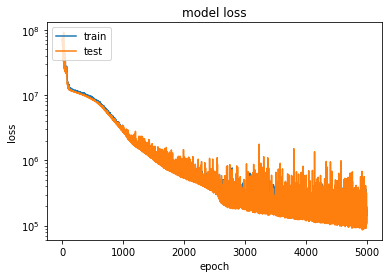

In [61]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.yscale('log')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [62]:
#y_pred = merged_model.predict([X_test_weather,X_test_stationary,X_test_GPS, GPS_label_test])
y_pred = merged_model.predict([X_test_weather,X_test_stationary, GPS_label_test])

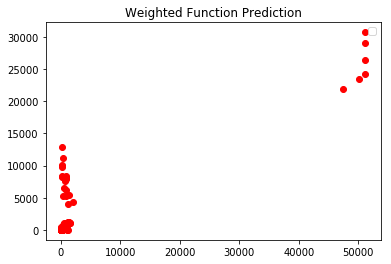

In [63]:
plt.scatter(y_test,y_pred, color = 'red')
plt.title('Weighted Function Prediction')
plt.legend()
plt.show()

In [64]:
mse = mean_squared_error(y_test, y_pred)
print mse

22578520.699758116
